In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm 
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# hide warning messages
import warnings
warnings.filterwarnings("ignore")

In [3]:
# better plots
sns.set(rc={'figure.figsize':(12,8)});

In [4]:
directory = os.path.dirname(os.getcwd())
directory

'd:\\github\\AssignmentEconometricsIV'

## Question

The third question consists of an inflation forecasting exercise using a large set of monthly macroeconomic variables and nonlinear models. As in the previous question, the forecasts are based on a rolling-window framework of fixed length of 492 observations, starting in January 1959. Therefore, the forecasts start on January 1990. The last forecasts are for November 2021. More specifically, the rolling window forecasting scheme can be described as follows:

1. Run all in-sample analysis and estimation using data from observation a to observation $a + 492 − 1$.
2. Compute the forecast for observation at position $a + 492$.
3. Set $a = a + 1$ and repeat the two steps above.

In [5]:
# read the data
input_path = f'{directory}\\data\\stacionarized_cpi.csv'
df = pd.read_csv(input_path)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [6]:
df.head()

,RPI,W875RX1,DPCERA3M086SBEA,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,...,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,INVEST
date,,,,,,,,,,,,,,,,,,,,,
1959-03-01,0.643011,0.735934,0.941009,0.832120,1.430253,0.603609,0.489927,0.000000,1.939697,-0.474508,...,0.000000,0.000000,-0.024978,0.066630,-0.112407,0.026180,-0.002184,-0.814665,0.481883,-1.479236
1959-04-01,0.649412,0.704864,-0.363947,0.061571,2.107741,1.433803,1.454234,1.565338,0.637947,1.651147,...,0.000000,0.000000,0.130473,-0.022927,0.134899,0.175237,-0.002163,1.220345,-0.488953,2.492924
1959-05-01,0.576311,0.661646,1.200535,0.780340,1.495024,0.826920,0.958304,0.476849,2.015117,0.000000,...,0.000000,0.000000,-0.143071,0.064631,-0.168653,-0.193673,-0.002143,-0.408972,-0.481929,-1.534223
1959-06-01,0.310244,0.297379,0.370829,0.906434,0.114438,0.703445,0.712642,-0.476849,0.745195,-0.704372,...,0.325204,0.337268,0.229263,0.032895,0.331580,0.209340,-0.461895,0.399176,0.479617,-1.225183
1959-07-01,-0.058921,-0.076384,-0.342687,-0.033018,-2.423797,0.116693,0.824692,1.305596,1.961284,0.821073,...,-0.001054,-0.001134,-0.074908,-0.152071,-0.123781,-0.010035,0.000000,-0.404015,-0.479617,2.934128


In [7]:
# set the amount of lags
lags = 2

In [8]:
# create lagged variables
for col in df.columns:
    for i in range(lags):
        name_col = col + f"(-{i+1})"
        df[name_col] = df[col].shift(i+1)

In [9]:
# inflation rate ahead
df['CPIAUCSL(+1)'] = df['CPIAUCSL'].shift(-1)

In [10]:
# drop nan rows
df = df.dropna()

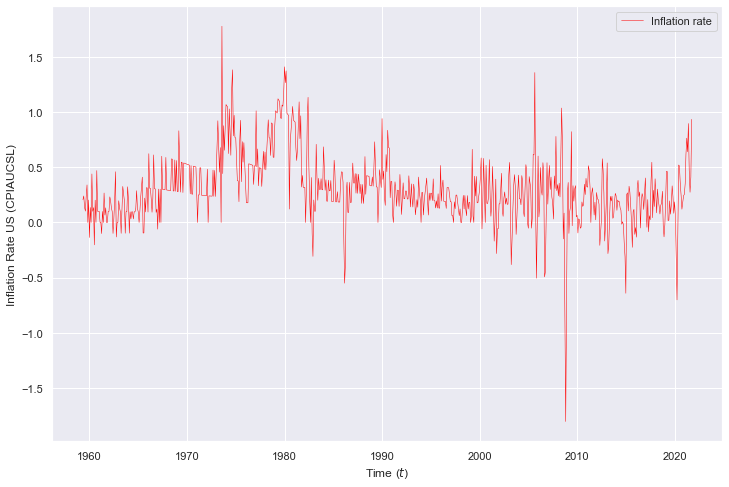

In [11]:
# plot Inflation rate of US
plt.plot(df['CPIAUCSL'], color='red', label='Inflation rate', linewidth = 0.5)

plt.xlabel(f'Time ($t$)')
plt.ylabel('Inflation Rate US (CPIAUCSL)')
plt.legend()
plt.show()

In [12]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

from functions.nonlinear_models import NN_forecast, LSTM_forecast

In [13]:
# set variables
y = df["CPIAUCSL(+1)"]
X = df.drop("CPIAUCSL(+1)", axis=1)

In [14]:
df

,RPI,W875RX1,DPCERA3M086SBEA,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,...,DSERRG3M086SBEA(-2),CES0600000008(-1),CES0600000008(-2),CES2000000008(-1),CES2000000008(-2),CES3000000008(-1),CES3000000008(-2),INVEST(-1),INVEST(-2),CPIAUCSL(+1)
date,,,,,,,,,,,,,,,,,,,,,
1959-05-01,0.576311,0.661646,1.200535,0.780340,1.495024,0.826920,0.958304,0.476849,2.015117,0.000000,...,0.026180,-0.002163,-0.002184,1.220345,-0.814665,-0.488953,0.481883,2.492924,-1.479236,0.240467
1959-06-01,0.310244,0.297379,0.370829,0.906434,0.114438,0.703445,0.712642,-0.476849,0.745195,-0.704372,...,0.175237,-0.002143,-0.002163,-0.408972,1.220345,-0.481929,-0.488953,-1.534223,2.492924,0.137221
1959-07-01,-0.058921,-0.076384,-0.342687,-0.033018,-2.423797,0.116693,0.824692,1.305596,1.961284,0.821073,...,-0.193673,-0.461895,-0.002143,0.399176,-0.408972,0.479617,-0.481929,-1.225183,-1.534223,0.102810
1959-08-01,-0.563656,-0.574751,0.600333,0.636421,-3.446532,-0.702622,-0.234750,0.117877,-2.831305,1.161607,...,0.209340,0.000000,-0.461895,-0.404015,0.399176,-0.479617,0.479617,2.934128,-1.225183,0.239316
1959-09-01,0.072136,0.000000,1.001845,-1.315700,-0.120914,-0.470898,-0.353804,-0.353743,-3.041963,0.575782,...,-0.010035,0.000000,0.000000,0.394453,-0.404015,-0.961546,-0.479617,-2.549545,2.934128,0.340716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,-0.268168,0.246839,0.588917,0.848804,0.546727,0.002528,0.114008,-0.202956,-1.515281,0.156910,...,-0.064121,-0.232967,0.072119,-0.802651,0.560450,0.209887,0.298788,0.058641,-0.293195,0.471599
2021-07-01,0.803329,0.376098,-0.313442,-1.637075,0.767226,1.461057,1.668025,0.970731,4.626890,-0.042815,...,-0.067356,0.110918,-0.232967,0.129753,-0.802651,-0.004596,0.209887,-0.716631,0.058641,0.273614
2021-08-01,-0.041013,-0.094940,0.727968,1.152697,-0.136496,-0.232743,-0.485054,-0.407293,-1.633303,-0.062902,...,0.065611,-0.116327,0.110918,-0.198770,0.129753,-0.046350,-0.004596,-0.488861,-0.716631,0.410742


In [15]:
# add forecast columns
df["CPIAUCSL_estimated_NN"] = np.nan
df["CPIAUCSL_estimated_LSTM"] = np.nan

### (a) (60 points) 

Estimate a model based on a neural network specification and compute one step ahead forecasts. You are free to choose between shallow, deep, convolution or LSTM networks. However, you have to motivate your particular choice;

In [16]:
# set some parameters
rolling_window = 492 - lags
T = len(y) - rolling_window

In [17]:
# list of forecast squared errors
errors_NN = []
errors_LSTM = []

for t in tqdm(range(T), desc='Processing for time'):
    # predict date
    date = y[[rolling_window+t]].index

    # estimation sets
    X_train = X[t:(rolling_window+t)]
    y_train = y[t:(rolling_window+t)]

    # forecast sets
    X_test = X.iloc[[rolling_window+t]]
    y_test = y[rolling_window+t]
    
    # estimations
    y_pred_NN, error_pred_NN = NN_forecast(X_train, y_train, X_test, y_test)
    y_pred_LSTM, error_pred_LSTM = LSTM_forecast(X_train, y_train, X_test, y_test)

    # fill forecast columns
    df["CPIAUCSL_estimated_NN"][date] = y_pred_NN
    df["CPIAUCSL_estimated_LSTM"][date] = y_pred_LSTM

    # append forecast squared errors
    errors_NN.append(error_pred_NN)
    errors_LSTM.append(error_pred_LSTM)

Processing for time:   1%|          | 2/260 [06:03<13:08:02, 183.26s/it]

Processing for time:  12%|█▏        | 30/260 [1:38:03<12:51:50, 201.35s/it]

In [21]:
df[["CPIAUCSL", "CPIAUCSL_estimated_NN", "CPIAUCSL_estimated_LSTM"]][rolling_window:]

,CPIAUCSL,CPIAUCSL_estimated_NN,CPIAUCSL_estimated_LSTM
date,,,
2000-03-01,0.584795,0.455555,0.336631
2000-04-01,-0.058514,0.034563,0.014773
2000-05-01,0.175234,NaN,NaN
2000-06-01,0.580720,NaN,NaN
2000-07-01,0.289519,NaN,NaN
...,...,...,...
2021-06-01,0.896742,NaN,NaN
2021-07-01,0.471599,NaN,NaN
2021-08-01,0.273614,NaN,NaN


In [87]:
# prediction dates
prediction_dates = list(X.iloc[(rolling_window):].index)

In [88]:
# treat the error list
errors_NN_ = [item[0] for item in errors_NN]
errors_LSTM_ = [item[0] for item in errors_LSTM]

# compute cumulated mse
cum_errors_NN = list(np.cumsum(errors_NN_))
cum_errors_LSTM = list(np.cumsum(errors_LSTM_))

In [89]:
errors = {'Cumulated_MSE_NN': cum_errors_NN, 'Cumulated_MSE_LSTM': cum_errors_LSTM}
mse = pd.DataFrame(errors, index=prediction_dates)

In [90]:
mse

,Cumulated_MSE_NN,Cumulated_MSE_LSTM
2000-01-01,0.007091,0.013450
2000-02-01,0.029769,0.052048
2000-03-01,0.039819,0.060598
2000-04-01,0.047518,0.146563
2000-05-01,0.060553,0.149753
...,...,...
2021-07-01,7.942950,13.468571
2021-08-01,7.961792,13.474094
2021-09-01,8.007845,13.486726
2021-10-01,8.192829,13.646829


### (b) (20 points) 

Plot you forecasts against the four linear benchmarks from Question 2. Comment on you results.

In [134]:
path_ridge = '../output/fcstridge.csv'
ridge = pd.read_csv(path_ridge, index_col=0)
ridge['date'] = pd.to_datetime(ridge['date'])
ridge = ridge.set_index('date')

In [135]:
ridge

,lag1,lag2,lag3,lag4
date,,,,
2000-07-01,0.369403,0.387019,0.418968,0.359388
2000-08-01,0.002054,-0.029253,-0.114299,0.358884
2000-09-01,0.494632,0.453980,0.515612,0.364157
2000-10-01,0.151252,0.112975,0.176248,0.361674
2000-11-01,0.247969,0.243784,0.246964,0.361788
...,...,...,...,...
2021-07-01,0.217308,0.283583,0.155219,0.240035
2021-08-01,0.080251,0.135076,0.086124,0.237282
2021-09-01,0.410580,0.285576,0.271047,0.238161


In [136]:
path_lasso = '../output/fcstlasso.csv'
lasso = pd.read_csv(path_lasso, index_col=0)
lasso['date'] = pd.to_datetime(lasso['date'])
lasso = lasso.set_index('date')

In [137]:
lasso

,lag1,lag2,lag3,lag4
date,,,,
2000-04-01,-0.220251,0.000000,0.000000,0.000000
2000-05-01,0.217981,0.256868,0.000000,0.000000
2000-06-01,0.568535,0.472142,0.454316,0.000000
2000-07-01,0.367095,0.382582,0.413487,0.359386
2000-08-01,-0.008437,-0.034442,-0.121800,0.358895
...,...,...,...,...
2021-07-01,0.215184,0.282906,0.154538,0.241215
2021-08-01,0.076033,0.133367,0.084613,0.238452
2021-09-01,0.405977,0.282209,0.267681,0.239301


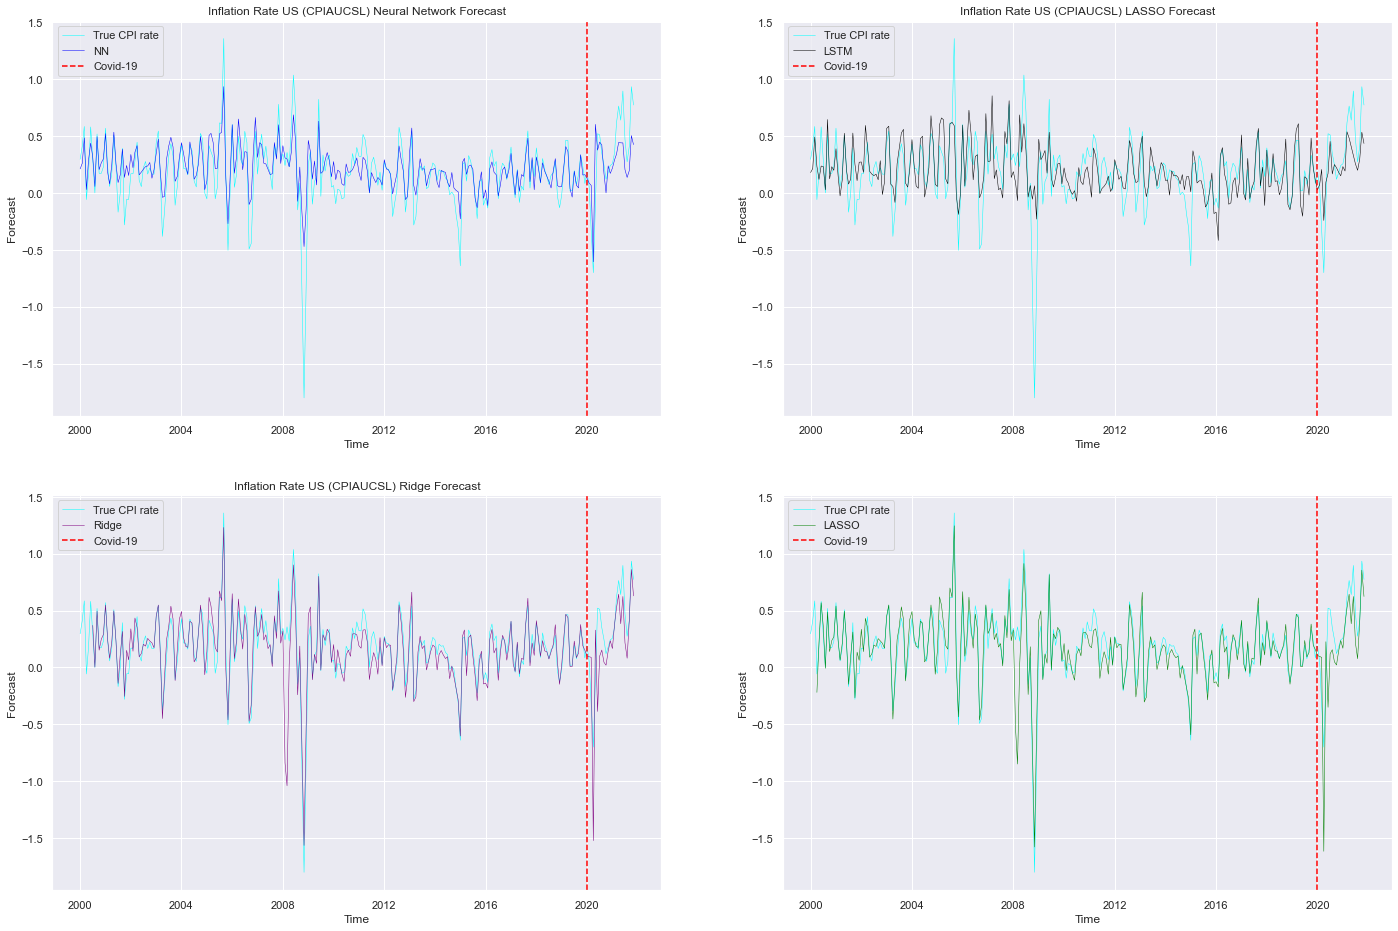

In [138]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 16))

# True CPI
axes[0,0].plot(df['CPIAUCSL'][rolling_window:], color='cyan', label='True CPI rate', linewidth=0.5)
# NN forecasts
axes[0,0].plot(df["CPIAUCSL_estimated_NN"], color='blue', label='NN', linewidth=0.5)
# adding a vertical line at 2020, January
axes[0,0].axvline(x=mse.index[240], color='red', linestyle='--', label='Covid-19')
# labels
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Forecast')
axes[0,0].set_title('Inflation Rate US (CPIAUCSL) Neural Network Forecast')
axes[0,0].legend()

# True CPI
axes[0,1].plot(df['CPIAUCSL'][rolling_window:], color='cyan', label='True CPI rate', linewidth=0.5)
# LSTM forecasts
axes[0,1].plot(df["CPIAUCSL_estimated_LSTM"], color='black', label='LSTM', linewidth=0.5)
# adding a vertical line at 2020, January
axes[0,1].axvline(x=mse.index[240], color='red', linestyle='--', label='Covid-19')
# labels
axes[0,1].set_xlabel('Time')
axes[0,1].set_ylabel('Forecast')
axes[0,1].set_title('Inflation Rate US (CPIAUCSL) LSTM Forecast')
axes[0,1].legend()

# True CPI
axes[1,0].plot(df['CPIAUCSL'][rolling_window:], color='cyan', label='True CPI rate', linewidth=0.5)
# Ridge
axes[1,0].plot(ridge["lag1"], color='purple', label='Ridge', linewidth=0.5)
# adding a vertical line at 2020, January
axes[1,0].axvline(x=mse.index[240], color='red', linestyle='--', label='Covid-19')
# labels
axes[1,0].set_xlabel('Time')
axes[1,0].set_ylabel('Forecast')
axes[1,0].set_title('Inflation Rate US (CPIAUCSL) Ridge Forecast')
axes[1,0].legend()

# True CPI
axes[1,1].plot(df['CPIAUCSL'][rolling_window:], color='cyan', label='True CPI rate', linewidth=0.5)
# LASSO
axes[1,1].plot(lasso["lag1"], color='green', label='LASSO', linewidth=0.5)
# adding a vertical line at 2020, January
axes[1,1].axvline(x=mse.index[240], color='red', linestyle='--', label='Covid-19')
# labels
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Forecast')
axes[0,1].set_title('Inflation Rate US (CPIAUCSL) LASSO Forecast')
axes[1,1].legend()

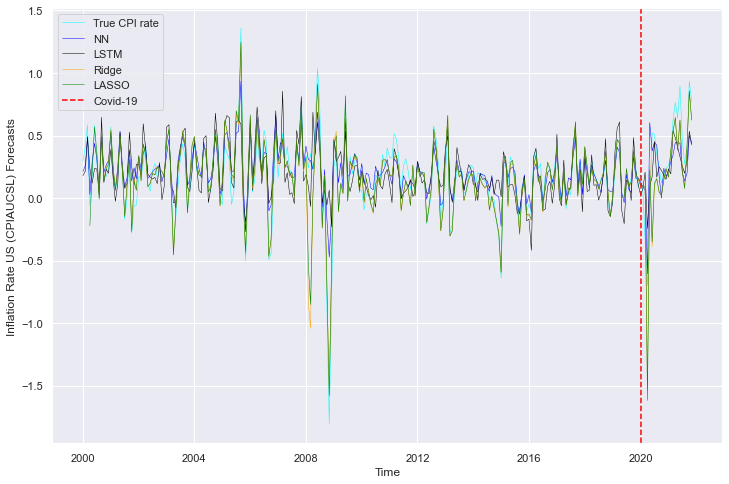

In [139]:
plt.plot(df['CPIAUCSL'][rolling_window:], color='cyan', label='True CPI rate', linewidth = 0.5)

plt.plot(df["CPIAUCSL_estimated_NN"], color='blue', label='NN', linewidth = 0.5)

plt.plot(df["CPIAUCSL_estimated_LSTM"], color='black', label='LSTM', linewidth = 0.5)

plt.plot(ridge["lag1"], color='orange', label='Ridge', linewidth = 0.5)

plt.plot(lasso["lag1"], color='green', label='LASSO', linewidth = 0.5)

# adding a vertical line at 2020, January
plt.axvline(x=mse.index[240], color='red', linestyle='--', label='Covid-19')

plt.xlabel('Time')
plt.ylabel('Inflation Rate US (CPIAUCSL) Forecasts')
plt.legend()
plt.show()

### (c) (20 points) 

Compute the mean squared error of the NN-based model and the benchmarks. Does the NN model outperform the linear alternative?

In [141]:
path_ridge = '../output/mseridge.csv'
ridge_mse = pd.read_csv(path_ridge, index_col=0)
ridge_mse.index = prediction_dates[3:]
ridge_mse = ridge_mse.drop('date', axis=1)

In [143]:
ridge_mse

,lag1,lag2,lag3,lag4,lag1cum,lag2cum,lag3cum,lag4cum
2000-04-01,0.026159,0.000000,0.000000,0.000000,0.026159,0.000000,0.000000,0.000000
2000-05-01,0.001827,0.006664,0.000000,0.000000,0.027986,0.006664,0.000000,0.000000
2000-06-01,0.000148,0.011789,0.015978,0.000000,0.028135,0.018453,0.015978,0.000000
2000-07-01,0.006018,0.008661,0.015368,0.004881,0.034153,0.027114,0.031346,0.004881
2000-08-01,0.000071,0.001186,0.014835,0.128806,0.034224,0.028300,0.046181,0.133687
...,...,...,...,...,...,...,...,...
2021-07-01,0.065749,0.035605,0.100528,0.053077,6.153445,3.353378,4.265732,28.508879
2021-08-01,0.039038,0.019669,0.035721,0.001236,6.192483,3.373048,4.301453,28.510116
2021-09-01,0.000023,0.016521,0.020466,0.029392,6.192506,3.389569,4.321919,28.539508
2021-10-01,0.006238,0.005831,0.028815,0.474513,6.198743,3.395399,4.350734,29.014021


In [145]:
path_lasso = '../output/mselasso.csv'
lasso_mse = pd.read_csv(path_lasso, index_col=0)
lasso_mse.index = prediction_dates[3:]
lasso_mse = lasso_mse.drop('date', axis=1)

In [146]:
lasso_mse

,lag1,lag2,lag3,lag4,lag1cum,lag2cum,lag3cum,lag4cum
2000-04-01,6.655035e-05,0.000000e+00,0.000000,0.000000,0.000067,0.000000,0.000000,0.000000
2000-05-01,5.644985e-05,4.871076e-05,0.000000,0.000000,0.000123,0.000049,0.000000,0.000000
2000-06-01,1.876490e-07,9.798849e-06,0.000003,0.000000,0.000123,0.000059,0.000003,0.000000
2000-07-01,1.573241e-05,1.109554e-05,0.000007,0.000011,0.000139,0.000070,0.000011,0.000011
2000-08-01,7.745130e-07,2.885865e-08,0.000002,0.000032,0.000140,0.000070,0.000013,0.000042
...,...,...,...,...,...,...,...,...
2021-07-01,2.841539e-04,3.285630e-04,0.000549,0.002269,0.032580,0.032892,0.041504,0.209310
2021-08-01,3.284802e-05,2.503044e-05,0.000060,0.000033,0.032613,0.032917,0.041564,0.209343
2021-09-01,4.200028e-05,1.237095e-04,0.000149,0.001349,0.032655,0.033041,0.041714,0.210692
2021-10-01,9.441506e-06,2.054710e-07,0.000067,0.003060,0.032665,0.033041,0.041780,0.213751


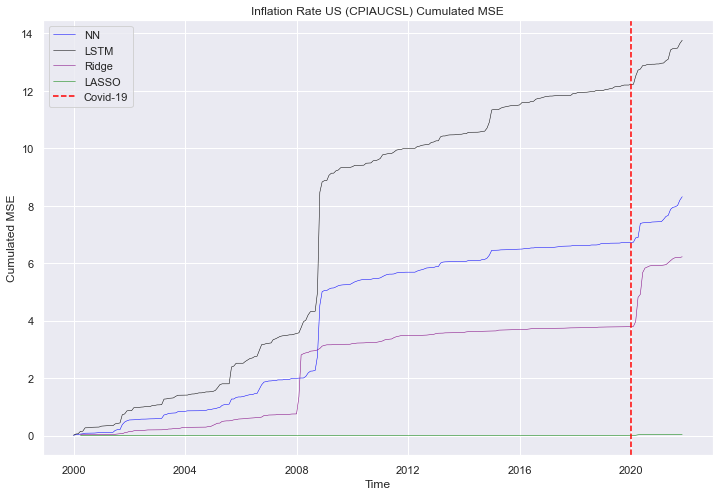

: 

In [148]:
# plot of cumulated MSE
plt.plot(mse["Cumulated_MSE_NN"], color='blue', label="NN", linewidth = 0.5)

# plot of cumulated MSE
plt.plot(mse["Cumulated_MSE_LSTM"], color='black', label="LSTM", linewidth = 0.5)

# plot of cumulated MSE
plt.plot(ridge_mse["lag1cum"], color='purple', label="Ridge", linewidth = 0.5)

# plot of cumulated MSE
plt.plot(lasso_mse["lag1cum"], color='green', label="LASSO", linewidth = 0.5)

# adding a vertical line at 2020, January
plt.axvline(x=mse.index[240], color='red', linestyle='--', label='Covid-19')

plt.xlabel('Time')
plt.ylabel('Cumulated MSE')
plt.title('Inflation Rate US (CPIAUCSL) Cumulated MSE')
plt.legend()
plt.show()

In [38]:
output = f'{directory}\\output\\NN_predictions.csv'
df[["CPIAUCSL", "CPIAUCSL_estimated_NN", "CPIAUCSL_estimated_LSTM"]].to_csv(output, sep=',', encoding='utf-8')

In [70]:
output = f'{directory}\\output\\NN_MSE.csv'
mse.to_csv(output, sep=',', encoding='utf-8')